### Data Upload

In [54]:
import numpy as np
import pickle
from sklearn.preprocessing import normalize

In [145]:
fileNames = ['vision','tel','sleep','shoulder','f2t','abPain','pal']
for i in fileNames:    
    exec(i + '= pickle.load( open( i, "rb" ) )') 
#
xVariables = pickle.load( open( "xVariables.p", "rb" ) )
yVariables = pickle.load( open( "yVariables.p", "rb" ) )

In [152]:
abPainText =abPain['Response']+abPain['NextSteps1']+abPain['NextSteps2']+abPain['NextSteps3']
f2tText = f2t['History']+f2t['DifferentialDiagnosis']+f2t['NextSteps']
palText = pal['Response']+pal['NextSteps1']+pal['NextSteps2']+pal['NextSteps3']
shoulderText = shoulder['History']+shoulder['PhysicalExamination']+shoulder['DifferentalDiagnosis']+shoulder['NextSteps']
sleepText = sleep['History']+sleep['MentalStatusExamination']+sleep['DifferentalDiagnosis']+sleep['NextSteps']
telText = tel['HISTORY']+tel['DIFFERENTIAL DIAGNOSIS']+tel['NEXT STEPS']
visionText = vision['History'] + vision['PhysicalExamination'] + vision['DifferentialDiagnosis'] + vision['NextSteps']

### word2vect

In [450]:
import gensim, logging
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn import metrics
from sklearn.cross_validation import train_test_split

In [37]:
#GoogleNews-vectors-negative300.bin can be downloaded from website
path = '/Users/YY/Documents/NYU/medicalC/'
model_word2vec = gensim.models.Word2Vec.load_word2vec_format(path+'GoogleNews-vectors-negative300.bin.gz', binary=True)

def veclist(l):
    a = []
    for i in xrange(len(l)):
        #print i
        a.append(np.zeros(300))
        if len(l[i]) > 0:
            for k in l[i]:
                try:
                    a[i] += model_word2vec[k]
                except KeyError:
                    continue
        else:
            a[i] = np.ones(300)/300
    return a

In [78]:
for f in fileNames:
    out = pd.DataFrame()
    for m in xVariables[f]:
        exec ('temp='+ f)
        colW2V= veclist(temp[m].values)
        colW2VN = normalize(colW2V)
        out = pd.concat([out,pd.DataFrame(colW2VN)], axis=1)  
        
        newName = m + "_len"
        out[newName] = len(temp[m])

    exec(f+'Xvec=out')

In [455]:
for f in fileNames:
    print f
    exec('xIn='+f+'Xvec')
    exec('yIn='+f+'["qual_clinical_reasoning"]')
    
    rf_grid = {'n_estimators':[20, 50, 100, 500], 'max_features':[1, 2]}
    svm_grid = {'C': [1000, 10000, 100000], 'gamma': [100, 10, 1, 0.1], 'kernel': ['linear', 'poly', 'rbf']}
    lr_grid = {'penalty':['l1','l2'],'C':[0.01,0.1,1,10]}

    kf = cross_validation.StratifiedKFold(yIn, n_folds=5 )

    rf_cv = GridSearchCV(RandomForestClassifier(), rf_grid, cv = kf, scoring = 'roc_auc')
    rf_cv.fit(xIn, yIn)

    svm_cv = GridSearchCV(SVC(), svm_grid, cv = kf, scoring = 'roc_auc')
    svm_cv.fit(xIn, yIn)
    svc = svm_cv.best_estimator_
    svc.probability = True

    lr_cv = GridSearchCV(LogisticRegression(), lr_grid, cv = kf, scoring = 'roc_auc')
    lr_cv.fit(xIn, yIn)

    print rf_cv.best_score_, svm_cv.best_score_, lr_cv.best_score_

vision
0.699723639456 0.626594387755 0.708333333333
tel
0.699003576903 0.744915687276 0.510219724067
sleep
0.807757137943 0.740763673891 0.628070175439
shoulder
0.758048032703 0.738630556975 0.723300970874
f2t
0.61295705594 0.619528619529 0.512404749247
abPain
0.651986336032 0.496255060729 0.662550607287
pal
0.657724408108 0.565661727133 0.567081133254


### TFIDF

In [440]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
for f in fileNames:
    print f
    exec('xIn='+f+'Text')
    exec('yIn='+f+'["qual_clinical_reasoning"]')
   
    X_train, X_test, Y_train, Y_test = train_test_split(xIn, yIn, train_size=0.8,stratify=yIn)
    tfidf_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range=(1,2)).fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    
    rf_grid = {'n_estimators':[20, 50, 100, 500], 'max_features':[1, 2]}
    svm_grid = {'C': [1000, 10000, 100000], 'gamma': [100, 10, 1, 0.1], 'kernel': ['rbf']}
    lr_grid = {'penalty':['l1','l2'],'C':[0.01,0.1,1,10]}

    kf = cross_validation.StratifiedKFold(Y_train, n_folds=3 )

    rf_cv = GridSearchCV(RandomForestClassifier(), rf_grid, cv = kf, scoring = 'roc_auc')
    rf_cv.fit(X_train, Y_train)
    rf_auc= metrics.roc_auc_score(rf_cv.predict(X_test), Y_test)

    svm_cv = GridSearchCV(SVC(), svm_grid, cv = kf, scoring = 'roc_auc')
    svm_cv.fit(X_train, Y_train)
    svc = svm_cv.best_estimator_
    svc.probability = True
    svc_auc = metrics.roc_auc_score(svc.predict(X_test), Y_test)

    lr_cv = GridSearchCV(LogisticRegression(), lr_grid, cv = kf, scoring = 'roc_auc')
    lr_cv.fit(X_train, Y_train)
    lr_auc= metrics.roc_auc_score(lr_cv.predict(X_test), Y_test)

    print rf_auc, svc_auc, lr_auc

### abPain, Sleep

In [458]:
temp = ['abPain', 'sleep']
for f in temp:
    list1 =[]
    list2 =[]
    list3 =[]
    for i in xrange(100):
        #if i%20 == 0:
            #print i
        exec('xIn='+f+'Text')
        exec('yIn='+f+'["qual_clinical_reasoning"]')
        #exec(yIn=sleepYcr)

        X_train, X_test, Y_train, Y_test = train_test_split(xIn, yIn, train_size=.80,stratify=yIn)
        tfidf_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range=(1,2)).fit(X_train)
        X_train = tfidf_vectorizer.transform(X_train)
        X_test = tfidf_vectorizer.transform(X_test)

        rf_grid = {'n_estimators':[20, 50, 100], 'max_features':[1, 2]}
        svm_grid = {'C': [1000, 10000, 100000], 'gamma': [100, 10, 1, 0.1], 'kernel': ['linear', 'poly', 'rbf']}
        lr_grid = {'penalty':['l1','l2'],'C':[0.01,0.1,1,10]}

        kf = cross_validation.StratifiedKFold(Y_train, n_folds=5 )

        rf_cv = GridSearchCV(RandomForestClassifier(), rf_grid, cv = kf, scoring = 'roc_auc')
        rf_cv.fit(X_train, Y_train)
        rf_auc= metrics.roc_auc_score(Y_test,rf_cv.predict_proba(X_test)[:,1])
        list1.append(rf_auc)

        svm_cv = GridSearchCV(SVC(), svm_grid, cv = kf, scoring = 'roc_auc')
        svm_cv.fit(X_train, Y_train)
        svc = svm_cv.best_estimator_
        svc.probability = True
        svc.fit(X_train, Y_train)
        svc_auc = metrics.roc_auc_score(Y_test, svc.predict_proba(X_test)[:,1])
        list2.append(svc_auc)

        lr_cv = GridSearchCV(LogisticRegression(), lr_grid, cv = kf, scoring = 'roc_auc')
        lr_cv.fit(X_train, Y_train)
        lr_auc= metrics.roc_auc_score(Y_test, lr_cv.predict_proba(X_test)[:,1])
        list3.append(lr_auc)
        
    exec('rf_auc_list_'+f+' =list1')
    exec('svc_auc_list_'+f+' =list2')
    exec('lr_auc_list_'+f+' =list3') 

        #print rf_auc, svc_auc, lr_auc

In [217]:
import matplotlib.pyplot as plt
%matplotlib inline

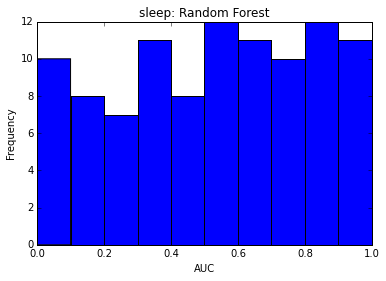

In [246]:
plt.hist(rf_auc_list_sleep)
plt.title("sleep: Random Forest")
plt.xlabel("AUC")
plt.ylabel("Frequency")

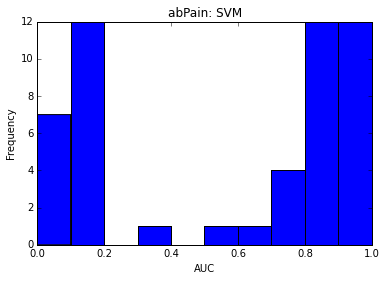

In [249]:
plt.hist(svc_auc_list)
plt.title("abPain: SVM")
plt.xlabel("AUC")
plt.ylabel("Frequency")

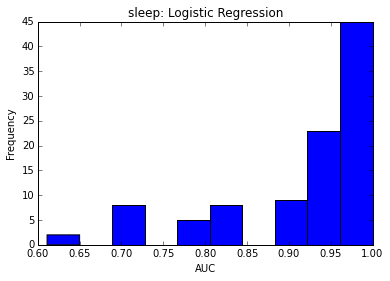

In [248]:
plt.hist(lr_auc_list_sleep)
plt.title("sleep: Logistic Regression")
plt.xlabel("AUC")
plt.ylabel("Frequency")

### Logistic Regression - abPain, Sleep

In [353]:
AUC_list =[]
mismatch =[]
list3 =[]
for i in xrange(1):
    xIn=abPainText
    yIn=abPain["qual_clinical_reasoning"]
    #exec(yIn=sleepYcr)

    X_train, X_test, Y_train, Y_test = train_test_split(xIn, yIn, train_size=.80,stratify=yIn)
    tfidf_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range=(1,2)).fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)

    lr_grid = {'penalty':['l1','l2'],'C':[0.01,0.1,1,10]}

    kf = cross_validation.StratifiedKFold(Y_train, n_folds=5 )

    lr_cv = GridSearchCV(LogisticRegression(), lr_grid, cv = kf, scoring = 'roc_auc')
    lr_cv.fit(X_train, Y_train)
    lr_auc= metrics.roc_auc_score(Y_test, lr_cv.predict_proba(X_test)[:,1])
    AUC_list.append(lr_auc)
    mismatch.append(abs(lr_cv.predict_proba(X_test)[:,1] - Y_test))
    

In [360]:
print lr_cv.predict_proba(X_test)[:,0] 
print [i for i in Y_test]

[ 0.08363091  0.0837729   0.08804109  0.07971621  0.09154361  0.0843715
  0.08620262  0.08549195  0.10048717  0.08794926  0.08961611  0.09560374
  0.07817384  0.1080274   0.09535981  0.07790283  0.08653147  0.07722583
  0.09986028  0.09977258  0.08866513]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


In [366]:
temp = lr_cv.predict_proba(X_test)[:,1]

In [367]:
temp1 = [i for i in Y_test]

In [377]:
new = pd.DataFrame([temp,temp1,Y_test.index])

### Feature Selection - coef rank

In [459]:
import operator
from collections import OrderedDict

In [430]:
import collections
feature = collections.defaultdict(list)

xIn=abPainText
yIn=abPain["qual_clinical_reasoning"]
for i in xrange(50):
    
    tr_x, va_t, tr_y, va_y = train_test_split(xIn, yIn, train_size=.80,stratify=yIn)

    tfidf_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range=(1,2)).fit(tr_x)
    xIn2 = tfidf_vectorizer.transform(xIn)
    feature_names = tfidf_vectorizer.get_feature_names()

    #va_x = tfidf_vectorizer.transform(test)


    logreg = LogisticRegression(penalty='l2',C=1)
    logreg.fit(xIn2,yIn)

    cof =logreg.coef_[0]
    cof2 = [(feature_names[i],cof[i]) for i,e in enumerate(cof) ]
    cof2.sort(key=lambda x: x[1])
    cof2 = [i[0] for i in cof2]
    cof3 = list(enumerate(cof2))
    
    for k,v in cof3:
        feature[v].append(k)
    
    #print len(cof) - cof.count(0)

In [432]:
avgFeatures = collections.OrderedDict()
for k,v in feature.iteritems():
    avgFeatures[k] = sum(v)/ float(len(v))

sorted_Ave = list(sorted(avgFeatures.items(), key=operator.itemgetter(1)))


In [435]:
sorted_Ave[-10:]

[(u'hcg', 7268.74),
 (u'exam', 7269.24),
 (u'rebound tenderness', 7272.46),
 (u'pregnancy', 7272.68),
 (u'ruptured', 7273.14),
 (u'ectopic', 7274.84),
 (u'rebound', 7276.3),
 (u'llq', 7276.32),
 (u'tenderness', 7277.66),
 (u'pelvic', 7278.78)]

In [436]:
sorted_Ave[:10]

[(u'appears', 0.0),
 (u'ct cbc', 2.36),
 (u'cbc bmp', 2.84),
 (u'describes', 3.3),
 (u'abdominal', 3.3),
 (u'abdominal ct', 3.66),
 (u'morning', 5.02),
 (u'bmp', 8.94),
 (u'socially', 11.306122448979592),
 (u'describes pain', 12.36)]